This notebook takes in the glims database as input and outputs a processed version of the database ready for earth engine consumption

In [1]:
import os
import geopandas as gpd
import pandas as pd
import pyproj
from collections import Counter
from datetime import datetime
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import mapping, Polygon
from shapely.ops import transform
import matplotlib.pyplot as plt

In [2]:
glacier_view_dir = os.path.join(os.path.expanduser("~"), "Desktop","projects","GlacierView")
glims_path = os.path.join(glacier_view_dir,"src","glims","data","glims_db_20210914","glims_polygons.shp")
df = gpd.read_file(glims_path, index_col = 0) 

In [471]:
rgi_examples = iter(df[df['geog_area'] == 'Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS'].geometry)

In [462]:
glob_glacier_examples = iter(df[df['geog_area'] == 'Various (GlobGlacier)'].geometry)

In [472]:
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32618')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform #this just makes the image larger

In [402]:
x = [coords[0] for coords in mapping(test)['coordinates'][0]]
y = [coords[1] for coords in mapping(test)['coordinates'][0]]

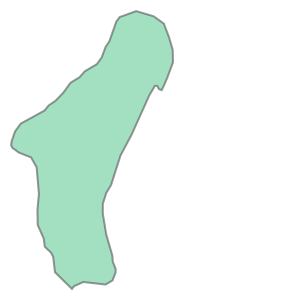

In [485]:
transform(project, next(rgi_examples))

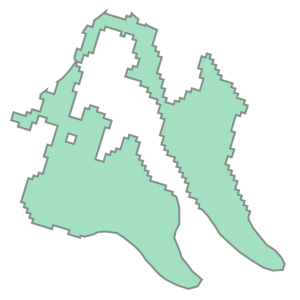

In [480]:
transform(project, next(glob_glacier_examples))

In [3]:
df['date'] = [datetime.strptime(dat.split("T")[0], '%Y-%m-%d') for dat in list(df.src_date)] #convert string dates to datetime

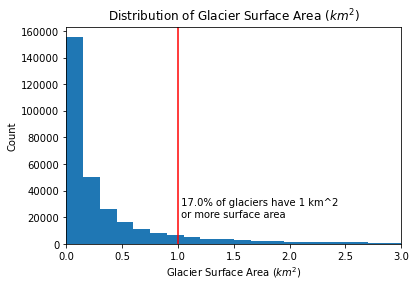

In [495]:
areas = list(df.groupby('glac_id')['db_area'].max())
plt.hist(areas, bins = np.arange(0,50,0.15))
plt.xlim(0,3)
plt.xlabel("Glacier Surface Area ($km^2$)")
plt.ylabel("Count")
plt.title("Distribution of Glacier Surface Area ($km^2$)")
plt.axvline(x = 1, color = 'r')
plt.text(1.0,20000,f' {round(np.mean(np.array(areas) > 1)*100,1)}% of glaciers have 1 km^2 \n or more surface area')
plt.show()

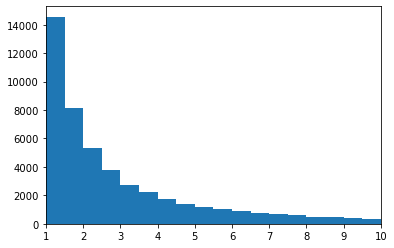

In [504]:
plt.hist(np.array(areas)[np.array(areas) > 1], bins = np.arange(0,50,0.5))
plt.xlim(1,10)
plt.show()

In [7]:
df[['glac_id','geog_area']].groupby('geog_area').glac_id.nunique().to_csv("glaciers_per_geog_area.csv")

In [10]:
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df.loc[df['date'] > datetime(2005,1,1)] #select glaciers with polygons drawn after 2005
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df[~df['geog_area'].isin(['Svalbard, Jan Mayen, and Bouvet', "Various (GlobGlacier)", 'Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS','Antarctic Peninsula','Various (NSIDC)'])]
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df[(df.db_area > 1) & (df.db_area < 50)] #nothing too small, nothing too large
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df.iloc[:,:-1] #ESRI shapefiles don't support datetime fields 

Unique glaciers: 328115
Unique glaciers: 170363
Unique glaciers: 122212
Unique glaciers: 18093


In [52]:
#remove glac ids which appear more than once in GLIMS (multiple annotations)
df = df.reset_index(drop = True)
clean_copy = df.copy()
s = set()
for i in range(df.shape[0]):
    if df.glac_id[i] in s:
        clean_copy = clean_copy.drop(i, axis = 0)
    else:
        s.add(df.glac_id[i])
df = clean_copy

In [53]:
ids = list(Counter(df.glac_id).keys()) #get list of unique ids
#df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) not needed anymore
gdf = gpd.GeoDataFrame(df, geometry = "geometry")

In [54]:
bboxes = []
for i in range(df.shape[0]):
    bboxes.append(list(zip(*np.asarray(gdf.iloc[[i],:].envelope.scale(xfact = 1.1, yfact = 1.1).squeeze().exterior.coords.xy))))
gdf['bboxes'] = [str(bbox) for bbox in bboxes]

In [60]:
gdf.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
gdf.to_file(os.path.join(glacier_view_dir,"src","glims","data","training_sample","glims_18k_bb.shp"))